
<div class="alert alert-info">

**This is a fixed-text formatted version of a Jupyter notebook**

- Try online [![Binder](https://static.mybinder.org/badge.svg)](https://mybinder.org/v2/gh/gammapy/gammapy-webpage/master?urlpath=lab/tree/cta.ipynb)
- You can contribute with your own notebooks in this
[GitHub repository](https://github.com/gammapy/gammapy/tree/master/docs/tutorials).
- **Source files:**
[cta.ipynb](../_static/notebooks/cta.ipynb) |
[cta.py](../_static/notebooks/cta.py)
</div>


# CTA with Gammapy

## Introduction

The [Cherenkov Telescope Array (CTA)](https://www.cta-observatory.org/) is the next generation ground-based observatory for gamma-ray astronomy.
Gammapy is a prototype for the Cherenkov Telescope Array (CTA) science tools ([2017ICRC...35..766D](https://ui.adsabs.harvard.edu/abs/2017ICRC...35..766D)).

CTA will start taking data in the coming years. For now, to learn how to analyse CTA data and to use Gammapy, if you are a member of the CTA consortium, you can use the simulated dataset from the CTA first data challenge which ran in 2017 and 2018.

- https://forge.in2p3.fr/projects/data-challenge-1-dc-1/wiki (CTA internal)

Gammapy fully supports the FITS data formats (events, IRFs) used in CTA 1DC. The XML sky model format is not supported, but are also not needed to analyse the data, you have to specify your model via the Gammapy YAML model format, or Python code, as shown below.

You can use Gammapy to simulate CTA data and evaluate CTA performance using the CTA response files available here:

- https://www.cta-observatory.org/science/cta-performance/

The current FITS format `CTA-Performance-prod3b-v2-FITS.tar` is fully supported by Gammapy, as shown below.

## Tutorial overview

This notebook shows how to access CTA data and instrument response functions (IRFs) using Gammapy, and gives some examples how to quick look the content of CTA files, especially to see the shape of CTA IRFs.

At the end of the notebooks, we give several links to other tutorial notebooks that show how to simulate CTA data and how to evaluate CTA observability and sensitivity, or how to analyse CTA data.

Note that the FITS data and IRF format currently used by CTA is the one documented at https://gamma-astro-data-formats.readthedocs.io/, and is also used by H.E.S.S. and other imaging atmospheric Cherenkov telescopes (IACTs). So if you see other Gammapy tutorials using e.g. H.E.S.S. example data, know that they also apply to CTA, all you have to do is to change the loaded data or IRFs to CTA.

## Setup

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import astropy
import gammapy

print("numpy:", np.__version__)
print("astropy:", astropy.__version__)
print("gammapy:", gammapy.__version__)

numpy: 1.19.1
astropy: 4.0.1.post1
gammapy: 0.18.dev392+g8257b1b93


In [3]:
from gammapy.data import DataStore, EventList
from gammapy.irf import EffectiveAreaTable2D, load_cta_irfs

## CTA 1DC

The CTA first data challenge (1DC) ran in 2017 and 2018. It is described in detail [here](https://forge.in2p3.fr/projects/data-challenge-1-dc-1/wiki) and a description of the data and how to download it is [here](https://forge.in2p3.fr/projects/data-challenge-1-dc-1/wiki#Data-access).

You should download `caldb.tar.gz` (1.2 MB), `models.tar.gz` (0.9 GB), `index.tar.gz` (0.5 MB), as well as optionally the simulated survey data you are interested in: Galactic plane survey `gps.tar.gz` (8.3 GB), Galactic center `gc.tar.gz` (4.4 MB), Extragalactic survey `egal.tar.gz` (2.5 GB), AGN monitoring `agn.wobble.tar.gz` (4.7 GB). After download, follow the instructions how to `untar` the files, and set a `CTADATA` environment variable to point to the data.

For convenience, since the 1DC data files are large, and not publicly available to anyone, we have taken a tiny subset of the CTA 1DC data, four observations with the southern array from the GPS survey, pointing near the Galactic center, and included them at `$GAMMAPY_DATA/cta-1dc` which you get via `gammapy download tutorials`.

### Files

Next we will show a quick overview of the files and how to load them, and some quick look plots showing the shape of the CTA IRFs. How to do CTA simulations and analyses is shown in other tutorials, see links at the end of this notebook.

In [4]:
!ls -1 $GAMMAPY_DATA/cta-1dc

README.md
caldb
data
index
make.py


In [5]:
!ls -1 $GAMMAPY_DATA/cta-1dc/data/baseline/gps

gps_baseline_110380.fits
gps_baseline_111140.fits
gps_baseline_111159.fits
gps_baseline_111630.fits


In [6]:
!ls -1 $GAMMAPY_DATA/cta-1dc/caldb/data/cta/1dc/bcf/South_z20_50h

irf_file.fits


In [7]:
!ls -1 $GAMMAPY_DATA/cta-1dc/index/gps

hdu-index.fits.gz
obs-index.fits.gz


### Datastore

You can use the `~gammapy.data.DataStore` to load via the index files

In [8]:
data_store = DataStore.from_dir("$GAMMAPY_DATA/cta-1dc/index/gps")
data_store

In [9]:
data_store.obs_table[["OBS_ID", "GLON_PNT", "GLAT_PNT", "IRF"]]

OBS_ID,GLON_PNT,GLAT_PNT,IRF
,deg,deg,
int64,float64,float64,bytes13
110380,359.9999912037958,-1.299995937905366,South_z20_50h
111140,358.4999833830074,1.3000020211954284,South_z20_50h
111159,1.5000056568267741,1.299940468335294,South_z20_50h
111630,263.9999985700299,-1.299980552289047,South_z20_50h


In [10]:
observation = data_store.obs(110380)
observation

## Events

We can load events data via the data store and observation, or equivalently via the `~gammapy.data.EventList` class by specifying the EVENTS filename.

The quick-look `events.peek()` plot below shows that CTA has a field of view of a few degrees, and two energy thresholds, one significantly below 100 GeV where the CTA large-size telescopes (LSTs) detect events, and a second one near 100 GeV where teh mid-sized telescopes (MSTs) start to detect events.

Note that most events are "hadronic background" due to cosmic ray showers in the atmosphere that pass the gamma-hadron selection cuts for this analysis configuration. Since this is simulated data, column `MC_ID` is available that gives an emission component identifier code, and the EVENTS header in `events.table.meta` can be used to look up which `MC_ID` corresponds to which emission component.

In [11]:
events = observation.events
events

In [12]:
events = EventList.read(
    "$GAMMAPY_DATA/cta-1dc/data/baseline/gps/gps_baseline_110380.fits"
)
events

In [13]:
events.table[:5]

EVENT_ID,TIME,RA,DEC,ENERGY,DETX,DETY,MC_ID
,s,deg,deg,TeV,deg,deg,
uint32,float64,float32,float32,float32,float32,float32,int32
1,664502403.0454683,-92.63541,-30.514854,0.03902182,-0.9077294,-0.2727693,2
2,664502405.2579999,-92.64103,-28.262728,0.030796371,1.3443842,-0.2838398,2
3,664502408.8205513,-93.20372,-28.599625,0.04009629,1.0049409,-0.7769775,2
4,664502409.0143764,-94.03383,-29.269627,0.039580025,0.32684833,-1.496021,2
5,664502414.8090746,-93.330505,-30.319725,0.03035851,-0.716062,-0.8733348,2


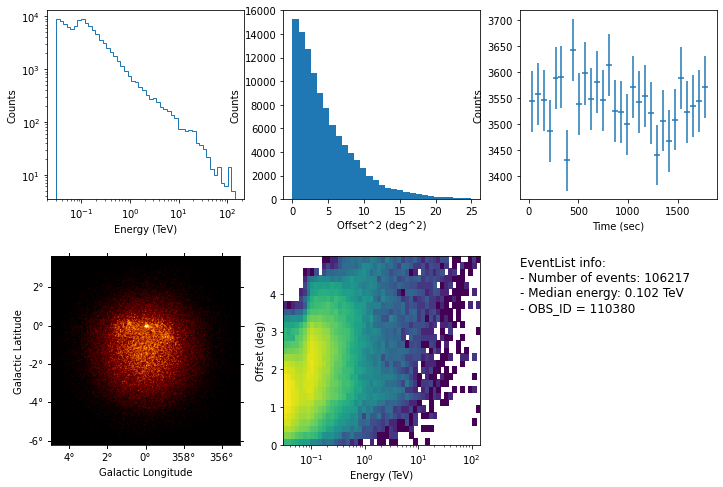

In [14]:
events.peek()

## IRFs

The CTA instrument reponse functions (IRFs) are given as FITS files in the `caldb` folder, the following IRFs are available:

- effective area
- energy dispersion
- point spread function
- background

Notes:

- The IRFs contain the energy and offset dependence of the CTA reponse
- CTA 1DC was based on an early version of the CTA FITS responses produced in 2017, improvements have been made since.
- The point spread function was approximated by a Gaussian shape
- The background is from hadronic and electron air shower events that pass CTA selection cuts. It was given as a function of field of view coordinates, although it is radially symmetric.
- The energy dispersion in CTA 1DC is noisy at low energy, leading to unreliable spectral points for some analyses.
- The CTA 1DC response files have the first node at field of view offset 0.5 deg, so to get the on-axis response at offset 0 deg, Gammapy has to extrapolate. Furthermore, because diffuse gamma-rays in the FOV were used to derive the IRFs, and the solid angle at small FOV offset circles is small, the IRFs at the center of the FOV are somewhat noisy. This leads to unstable analysis and simulation issues when using the DC1 IRFs for some analyses.

In [15]:
observation.aeff

In [16]:
irf_filename = (
    "$GAMMAPY_DATA/cta-1dc/caldb/data/cta/1dc/bcf/South_z20_50h/irf_file.fits"
)
irfs = load_cta_irfs(irf_filename)
irfs

Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)


{'aeff': <gammapy.irf.effective_area.EffectiveAreaTable2D at 0x7fd8993785c0>,
 'bkg': <gammapy.irf.background.Background3D at 0x7fd898041b00>,
 'edisp': <gammapy.irf.energy_dispersion.EnergyDispersion2D at 0x7fd89802dcf8>,
 'psf': <gammapy.irf.psf_gauss.EnergyDependentMultiGaussPSF at 0x7fd8980416d8>}

### Effective area

In [17]:
# Equivalent alternative way to load IRFs directly
aeff = EffectiveAreaTable2D.read(irf_filename, hdu="EFFECTIVE AREA")
aeff

/home/runner/work/gammapy-docs/gammapy-docs/gammapy/gammapy/irf/effective_area.py:541: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  caxes = ax.pcolormesh(energy.value, offset.value, aeff.value.T, **kwargs)


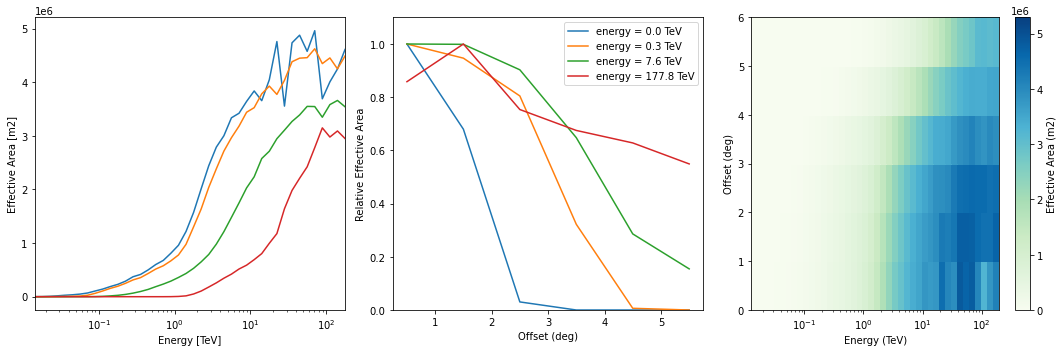

In [18]:
irfs["aeff"].peek()

In [19]:
# What is the on-axis effective area at 10 TeV?
aeff.data.evaluate(energy_true="10 TeV", offset="0 deg").to("km2")

<Quantity [3.78358697] km2>

### Energy dispersion


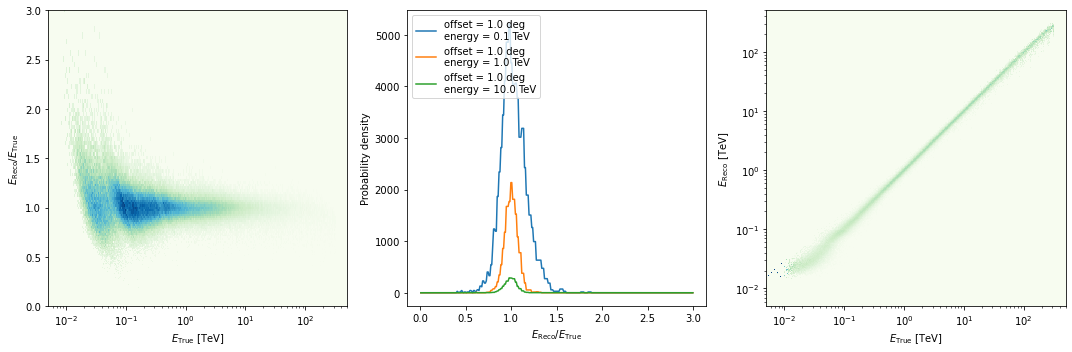

In [20]:
irfs["edisp"].peek()

### Point spread function


/home/runner/work/gammapy-docs/gammapy-docs/gammapy/gammapy/irf/psf_gauss.py:291: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  caxes = ax.pcolormesh(x, y, containment.value, **kwargs)


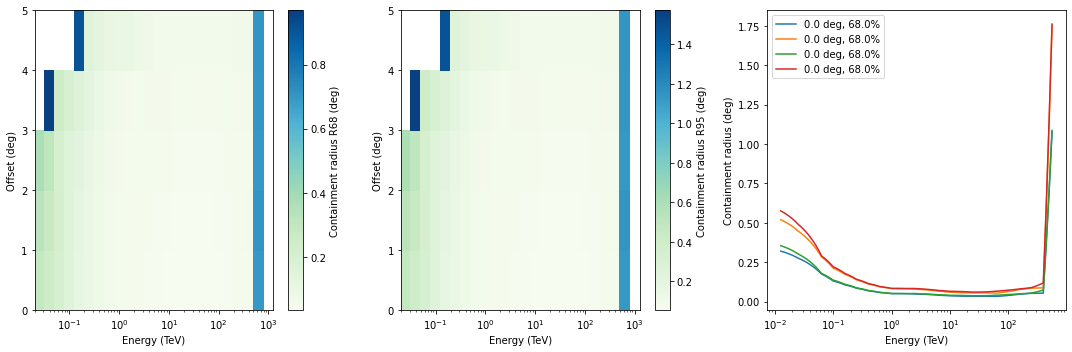

In [21]:
irfs["psf"].peek()

In [22]:
# This is how for analysis you could slice out the PSF
# at a given field of view offset
psf = irfs["psf"].to_energy_dependent_table_psf("1 deg")

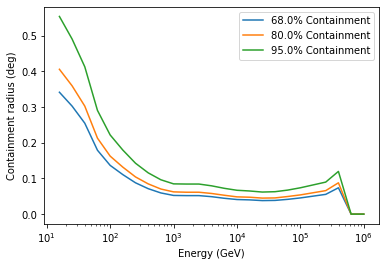

In [23]:
psf.plot_containment_vs_energy()

### Background

The background is given as a rate in units `MeV-1 s-1 sr-1`.

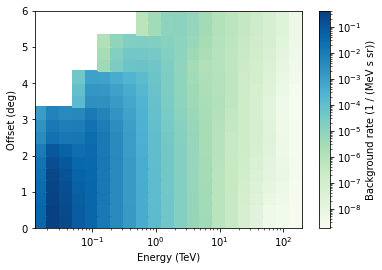

In [24]:
# TODO: add plot method to `Background3D`.
# FIXME: Background2D.peek` is broken.
irfs["bkg"].to_2d().plot()

In [25]:
irfs["bkg"].data.evaluate(energy="3 TeV", fov_lon="1 deg", fov_lat="0 deg")

<Quantity [1.20533163e-05] 1 / (MeV s sr)>

## Source models

The 1DC sky model is distributed as a set of XML files, which in turn link to a ton of other FITS and text files. Gammapy doesn't support this XML model file format. We are currently developing a YAML based format that improves upon the XML format, to be easier to write and read, add relevant information (units for physical quantities), and omit useless information (e.g. parameter scales in addition to values).

If you must or want to read the XML model files, you can use e.g. [ElementTree](https://docs.python.org/3/library/xml.etree.elementtree.html) from the Python standard library, or [xmltodict](https://github.com/martinblech/xmltodict) if you `pip install xmltodict`. Here's an example how to load the information for a given source, and to convert it into the sky model format Gammapy understands.

In [26]:
# This is what the XML file looks like
# !tail -n 20 $CTADATA/models/models_gps.xml

In [27]:
# TODO: write this example!

# Read XML file and access spectrum parameters
# from gammapy.extern import xmltodict

# filename = os.path.join(os.environ["CTADATA"], "models/models_gps.xml")
# data = xmltodict.parse(open(filename).read())
# data = data["source_library"]["source"][-1]
# data = data["spectrum"]["parameter"]
# data

In [28]:
# Create a spectral model the the right units
# from astropy import units as u
# from gammapy.modeling.models import PowerLawSpectralModel

# par_to_val = lambda par: float(par["@value"]) * float(par["@scale"])
# spec = PowerLawSpectralModel(
#     amplitude=par_to_val(data[0]) * u.Unit("cm-2 s-1 MeV-1"),
#     index=par_to_val(data[1]),
#     reference=par_to_val(data[2]) * u.Unit("MeV"),
# )
# print(spec)

## CTA performance files

CTA 1DC is useful to learn how to analyse CTA data. But to do simulations and studies for CTA now, you should get the most recent CTA IRFs in FITS format from https://www.cta-observatory.org/science/cta-performance/

If you want to run the download and examples in the next code cells, remove the # to uncomment.

In [29]:
# !curl -O https://www.cta-observatory.org/wp-content/uploads/2019/04/CTA-Performance-prod3b-v2-FITS.tar.gz

In [30]:
# !tar xf CTA-Performance-prod3b-v2-FITS.tar.gz

In [31]:
# !ls caldb/data/cta/prod3b-v2/bcf

In [32]:
# irfs1 = load_cta_irfs("caldb/data/cta/prod3b-v2/bcf/South_z20_50h/irf_file.fits")
# irfs1["aeff"].plot_energy_dependence()

In [33]:
# irfs2 = load_cta_irfs("caldb/data/cta/prod3b-v2/bcf/South_z40_50h/irf_file.fits")
# irfs2["aeff"].plot_energy_dependence()

## Exercises

* Load the EVENTS file for `obs_id=111159` as a `~gammapy.data.EventList` object.
* Use `events.table` to find the energy, sky coordinate and time of the highest-energy envent.
* Use `events.pointing_radec` to find the pointing position of this observation, and use `astropy.coordinates.SkyCoord` methods to find the field of view offset of the highest-energy event.
* What is the effective area and PSF 68% containment radius of CTA at 1 TeV for the `South_z20_50h` configuration used for the CTA 1DC simulation?
* Get the latest CTA FITS performance files from https://www.cta-observatory.org/science/cta-performance/ and run the code example above. Make an effective area ratio plot of 40 deg zenith versus 20 deg zenith for the `South_z40_50h` and `South_z20_50h` configurations.

In [34]:
# start typing here ...

## Next steps

* Learn how to analyse data with [analysis_1.ipynb](analysis_1.ipynb) and [analysis_2.ipynb](analysis_2.ipynb) or any other Gammapy analysis tutorial.
* Learn how to evaluate CTA observability and sensitivity with [simulate_3d.ipynb](simulate_3d.ipynb), [spectrum_simulation.ipynb](spectrum_simulation.ipynb) or [cta_sensitivity.ipynb](cta_sensitivity.ipynb)